# Topic Modeling Nike Product Reviews: Marketing and Product Insights

## Introduction

This project applies topic modeling to online reviews of Nike products to extract actionable insights for marketing and product development. The dataset comes from the Amazon Product Data repository, containing 8,327 distinct Nike products and 21,570 reviews.

## Methods

### Data Cleaning

Removed stopwords, punctuation, and numbers

Converted text to lowercase

Kept only words with ≥3 characters

Applied lemmatization to reduce words to base form

### Vectorization

Reviews were vectorized using TF–IDF for text analysis.

### Topic Modeling

Several topic counts were tested; 75 topics provided the most interpretable and granular results.

Each review was assigned to a topic, allowing both frequency-based and sentiment-based analysis.

### Sentiment Analysis

Sentiments were labeled using TextBlob (positive, neutral, negative).

To improve clarity, review ratings (≥4 = positive, ≤2 = negative) were also used to validate sentiment results.

## Results

### Topic Distribution

Using the review_count_topic explorer chart, we can easily see the most talked about topics.

A pie chart also highlights the top 5 and bottom 5 topics by review count.

### Reviewer Patterns

Most prolific reviewer submitted 11 reviews.

Across the dataset, there were 20,423 unique reviewers, indicating a wide and diverse customer base.

### Seasonality Trends

Review counts peak in spring and holiday season, with dips in late summer through winter.

Monthly review volumes were aggregated across all 75 topics to visualize seasonal demand.

### Sentiment by Topic

Top 10 topics with the highest negative-to-positive sentiment ratios were identified.

Specific thematic categories (e.g., price, comfort, durability, design, fit, performance) were analyzed across topics.

Highlighted Topics

Topic 11 (Watches): Negative reviews mention band and battery issues; positives highlight satisfaction with watch purchases.

Topic 36 (Bags): Complaints about money, strap, and size. Lack of pockets is a recurring theme.

Topic 45 (Shoes – Sizing): Frequent mention of small and fit, even in positive reviews, suggesting sizing runs small.

Topic 24 (Shoes – Fit): Complaints about airmax having a poor fit and support/

Topic 43 (Comfort): negative fit, hurting toes, arch and sizing support issues.

### Product-Level Insights

Topic-level ASIN analysis shows divergence between products with positive vs. negative reviews.

Example: Topic 45 negatives focus on sandals and watches with sizing issues, while positives celebrate successful watch purchases.

Topic 43’s negative reviews consistently cite sizing issues across multiple product types, highlighting the need for clear sizing guidance.

## Conclusion

Topic modeling and sentiment analysis reveal actionable insights for Nike product teams:

Marketing: Address customer concerns (e.g., “add pockets to bags,” “offer free sizing exchanges”).

Product Development: Improve sizing consistency, strap durability, comfort, and watch battery life.

### Future Work: 
Expand to product categories, customer segmentation, and deeper item-level review clustering.

 Sentiment analysis on single words. if "watch strap" is always mentioned negatively, seeing it in both positive and negative reviews can indicate a truthful criticism. 

*Model used was LDA (Latent Dirichlet Allocation) which analyzes word frequencies and their distributions across reviews, taking a Bayesian approach and Dirichlet distributions to model the topic and word probabilities.*

In [3]:
# ==========================
# 1. IMPORT LIBRARIES
# ==========================
import pandas as pd
import json
import ast
import gzip
import re
import itertools
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans

from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

import warnings
warnings.filterwarnings('ignore')



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\forca\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [81]:
import plotly.io as pio
pio.renderers.default = "iframe"


In [5]:
import gzip
import ast  # safe for parsing Python-literal dicts
import itertools
import pandas as pd

# ==========================
# 1. LOAD PRODUCT METADATA
# ==========================
META_FILE = "meta_Clothing_Shoes_and_Jewelry.json.gz"

nike_asins = []

with gzip.open(META_FILE, "rt", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        try:
            # Parse Python-style dict
            data = ast.literal_eval(line)
            categories = [c.lower() for c in itertools.chain(*data.get("categories", []))]
            if "nike" in categories:
                nike_asins.append(data["asin"])
        except Exception as e:
            print("Skipping line due to parse error:", e)

print(f"Found {len(nike_asins)} Nike ASINs")

# ==========================
# 2. LOAD REVIEW DATA
# ==========================
REV_FILE = "reviews_Clothing_Shoes_and_Jewelry.json.gz"

reviews_list = []

with gzip.open(REV_FILE, "rt", encoding="utf-8") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        try:
            data = ast.literal_eval(line)
            if data.get("asin") in nike_asins:
                reviews_list.append({
                    "asin": data.get("asin"),
                    "reviewText": data.get("reviewText"),
                    "overall": data.get("overall"),
                    "reviewerID": data.get("reviewerID"),
                    "reviewTime": data.get("reviewTime")
                })
        except Exception as e:
            print("Skipping line due to parse error:", e)

reviews_df = pd.DataFrame(reviews_list)
print(f"Found {len(reviews_df)} reviews for Nike products")

print(reviews_df.head())


Found 8327 Nike ASINs
Found 21570 reviews for Nike products
         asin                                         reviewText  overall  \
0  B0000V9K32  the colour i received is not blue as shown but...      3.0   
1  B0000V9K32  Very cute and is really practical. Fits better...      5.0   
2  B0000V9K3W  The watch was exactly what i ordered and I got...      4.0   
3  B0000V9K46  This product came promptly and as described, p...      5.0   
4  B0000V9KNM  Why isn't Nike making these anymore?  I love t...      4.0   

       reviewerID   reviewTime  
0   ACT5DY536GISV  07 27, 2009  
1  A3BVWMS9I8OH8U  12 26, 2009  
2   A5RZS69KSJH00  10 24, 2009  
3  A3F8O512N9UNVM  03 26, 2008  
4  A2EAKTCKFRF7A4  11 16, 2011  


In [6]:
# ==========================
# 3. TEXT CLEANING
# ==========================
from nltk.stem import WordNetLemmatizer
stop_words = set(stopwords.words('english'))
# Optionally add brand-specific stopwords like 'nike'
domain_stop_words = {'nike', 'shoe','shox'}
stop_words = stop_words.union(domain_stop_words)
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = str(text).lower()
    # Basic cleaning
    text = re.sub(r'[^a-z\s]', '', text)  # remove punctuation/numbers
    # split and filter
    words = [lemmatizer.lemmatize(w) for w in text.split() 
             if w not in stop_words and len(w) >= 3]
    return ' '.join(words)

reviews_df['cleaned'] = reviews_df['reviewText'].apply(clean_text)
reviews_df = reviews_df.sort_values("reviewerID").reset_index(drop=True)

reviews_df

,asin,reviewText,overall,reviewerID,reviewTime,cleaned
0,B0059CZYZK,Love these shoes they are exactly what I expec...,5.0,A00048402HORE3QTPBT0H,"09 11, 2013",love shoe exactly expected made purchase happy...
1,B00EIX9V50,me likey,4.0,A00151103W37UJ3ZZ2WDZ,"07 15, 2014",likey
2,B004UBXO9Y,"Very comfortable! Classic look, we bought thes...",5.0,A004875812MJTQHCFUM9A,"09 7, 2013",comfortable classic look bought nephew loved s...
3,B0036DRWKO,"I'm a medium & did run too small, should've pu...",2.0,A00490343DIBMWH39VA7P,"04 26, 2014",medium run small shouldve purchased large like...
4,B004UBXO9Y,I simply needed some nice comfortable running ...,5.0,A006414023SP9U65R2DT4,"06 14, 2013",simply needed nice comfortable running shoesiv...
...,...,...,...,...,...,...
21565,B004UBXO9Y,"Comprar ropas nike son una maravilla, es elega...",5.0,AZYC2HOBWU9HU,"12 13, 2011",comprar ropas son una maravilla elegancias par...
21566,B003NYUSPM,I use the socks for officiating basketball and...,5.0,AZYYTR61UVH1W,"07 15, 2013",use sock officiating basketball comfortable so...
21567,B006H3BVKC,These shorts are great for walking and jogging...,4.0,AZZKXNSXR6KBE,"05 17, 2014",short great walking jogging got feel good alth...
21568,B006BCABFK,We bought these cleats last fall when my son o...,1.0,AZZSRMU98AW5G,"04 25, 2013",bought cleat last fall son outgrew cleat mid s...


In [7]:
# ==========================
# 4. VECTORIZE TEXT
# ==========================
# Using TF-IDF vectorization
vectorizer = TfidfVectorizer(max_df=0.95, min_df=5)
X = vectorizer.fit_transform(reviews_df['cleaned'])


In [8]:
# ==========================
# 5a. TOPIC MODELING (LDA)
# ==========================
num_topics = 75  # Adjust to your dataset and interpretability
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(X)

# Function to display top words per topic
def display_topics(model, feature_names, no_top_words):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
        topics[topic_idx] = top_words
        print(f"Topic {topic_idx}: {' '.join(top_words)}")
    return topics

#feature_names = vectorizer.get_feature_names_out()
#topics = display_topics(lda, feature_names, 10)



In [9]:
# ==========================
# 5b. Display Top 4 Words per Topic AND store them
# ==========================
topic_top_words = {}  # dictionary for mapping topic → top words string

for idx, topic in enumerate(lda.components_):
    top_words = [vectorizer.get_feature_names_out()[i] 
                 for i in topic.argsort()[-7:][::-1]]
    topic_top_words[idx] = ", ".join(top_words)  # store as string
    print(f"Topic {idx}: {top_words}")


Topic 0: ['advertised', 'sister', 'rub', 'vendor', 'turned', 'call', 'silver']
Topic 1: ['shoe', 'size', 'pair', 'like', 'get', 'return', 'amazon']
Topic 2: ['jean', 'combination', 'asked', 'fitting', 'color', 'plan', 'look']
Topic 3: ['opened', 'hate', 'wrong', 'mall', 'twice', 'kobe', 'today']
Topic 4: ['cute', 'tshirt', 'mail', 'finally', 'seemed', 'soooo', 'stayed']
Topic 5: ['insert', 'wait', 'hardly', 'loosen', 'shame', 'flexibility', 'weird']
Topic 6: ['cleat', 'baby', 'baseball', 'avid', 'ready', 'football', 'soccer']
Topic 7: ['confortable', 'expecting', 'shoe', 'washing', 'vibrant', 'plain', 'sock']
Topic 8: ['dirty', 'third', 'clean', 'shoe', 'great', 'pair', 'lol']
Topic 9: ['jacket', 'loose', 'complain', 'father', 'sturdy', 'snow', 'glow']
Topic 10: ['grandson', 'birthday', 'arrived', 'shoe', 'condition', 'son', 'great']
Topic 11: ['watch', 'band', 'wrist', 'time', 'easy', 'one', 'feature']
Topic 12: ['correct', 'sandal', 'regret', 'five', 'word', 'bike', 'flex']
Topic 13:

In [10]:

# ==========================
# 5c. ASSIGN TOPICS TO REVIEWS
# ==========================
topic_assignments = lda.transform(X)
reviews_df['topic'] = topic_assignments.argmax(axis=1)

# Map the dictionary into the DataFrame
reviews_df["topic_top_words"] = reviews_df["topic"].map(topic_top_words)

reviews_df[["reviewText", "topic", "topic_top_words"]].head()



,reviewText,topic,topic_top_words
0,Love these shoes they are exactly what I expec...,58,"exactly, service, product, described, great, c..."
1,me likey,0,"advertised, sister, rub, vendor, turned, call,..."
2,"Very comfortable! Classic look, we bought thes...",21,"gift, christmas, love, bought, son, loved, nephew"
3,"I'm a medium & did run too small, should've pu...",45,"size, small, bigger, half, shoe, fit, run"
4,I simply needed some nice comfortable running ...,2,"jean, combination, asked, fitting, color, plan..."


In [11]:
# ==========================
# 6. SAMPLE INSPECTION
# ==========================
# Print a few reviews per topic with ASIN
for t in range(num_topics):
    print(f"\n=== Topic {t} ===")
    sample = reviews_df[reviews_df['topic'] == t].head(5)
    for _, row in sample.iterrows():
        print(f"ASIN: {row['asin']}, Review: {row['reviewText'][:100]}...")
        



=== Topic 0 ===
ASIN: B00EIX9V50, Review: me likey...
ASIN: B00I9Z7C2W, Review: They were a gift but the feedback i got from my sister is all positive. She loves them. I would reco...
ASIN: B00CHNGF8E, Review: alalalala...
ASIN: B0057FRV2S, Review: I bought these sneakers for my son and had them shipped to his home. He loves them, and he received ...
ASIN: B004XWGBJK, Review: For me this style of running shoes (I run 30-40 miles a week) had turned out to be the very best in ...

=== Topic 1 ===
ASIN: B00DW9MMWA, Review: The bra was too tight.. it's not about the size, it is the material.. it barely stretches.. I wanted...
ASIN: B005OBBFGS, Review: The shoe wore well. Was a comfortable fit from the start. Great color. I've never had a problem orde...
ASIN: B005OB65TK, Review: I bought these shoes when I started a workout routine.  They are light, good support.  I fight heal ...
ASIN: B00BZ4XYMG, Review: The shoe is very light. I ordered it for my Les Mills Body Pump class, and unfortun

### 13 topics

Topics 0, 2, 4, 5, 6, 8 → positive product themes (comfort, gym shoes, family gifts, socks).

Topics 7, 11, 12 → negative themes (fit issues, sizing, color expectations).

Topics 1, 9, 10 → niche products (Spanish reviews, watches, sandals/backpacks).

### 29 topics
Topics 0–8: Shoes and comfort are dominant.

Topics 9, 14, 16, 19: Accessories like watches and general appearance.

Topics 12, 22: Bags, hats, and sports gear.

Topics 15, 23: Food or non-shoe products (Spanish reviews or consumables).

Many topics reflect comfort, fit, and gift-giving as the main themes.

### 75 topics (most definitive)

**Topic 1 – Shoe sizing and returns**

Keywords: 'shoe', 'size', 'pair', 'like', 'get', 'return', 'amazon'

Insight: Focused on sizing issues and return experiences, useful for addressing fit complaints and return policies.

**Topic 11 – Watches / wristbands**

Keywords: 'watch', 'band', 'wrist', 'time', 'easy', 'one', 'feature'

Insight: Clearly about watches; keywords indicate design, usability, and band issues.

**Topic 20 – Bags / pockets**

Keywords: 'pocket', 'bag', 'stuff', 'gym', 'played', 'hold', 'zipper'

Insight: Bags and gym storage; problems or features can be directly addressed in product design.

**Topic 24 – Popular shoe models (Air Max)**

Keywords: 'max', 'air', 'ever', 'fan', 'shoe', 'best', 'comfortable'

Insight: Clearly references a specific model; very actionable for marketing and product improvement.

**Topic 25 – Apparel / surprise / sale items**

Keywords: 'loving', 'surprised', 'guy', 'como', 'sale', 'ultra', 'awhile'

Insight: Indicates customer reactions to apparel or limited edition items; good for marketing campaigns.

**Topic 36 – Gym bags**

Keywords: 'bag', 'gym', 'carry', 'kick', 'lower', 'colorway', 'perfect'

Insight: Gym and sports bags; feedback on size, color, and usability.

**Topic 43 – Foot support / running shoes**

Keywords: 'foot', 'shoe', 'toe', 'running', 'support', 'arch', 'run'

Insight: Running-specific shoes, arch support, and fit issues; very precise.

**Topic 45 – Shoe sizing complaints**

Keywords: 'size', 'small', 'bigger', 'half', 'shoe', 'fit', 'run'

Insight: Sizing concerns; actionable for marketing and sizing charts.

**Topic 50 – Uncomfortable shoes**

Keywords: 'uncomfortable', 'shoe', 'foot', 'pair', 'thinking', 'one', 'plastic'

Insight: Pain points related to comfort and materials; clearly negative sentiment.

**Topic 6 – Sports cleats**

Keywords: 'cleat', 'baby', 'baseball', 'avid', 'ready', 'football', 'soccer'

Insight: Targeted to sports footwear; very clear category for marketing.

**Topic 23 - Spanish Reviews**

In [13]:
# ==========================
# 10. SAVE RESULTS
# ==========================
reviews_df.to_csv("nike_reviews_with_topics.csv", index=False)

df1= pd.read_csv("nike_reviews_with_topics.csv")
df1


,asin,reviewText,overall,reviewerID,reviewTime,cleaned,topic,topic_top_words
0,B0059CZYZK,Love these shoes they are exactly what I expec...,5.0,A00048402HORE3QTPBT0H,"09 11, 2013",love shoe exactly expected made purchase happy...,58,"exactly, service, product, described, great, c..."
1,B00EIX9V50,me likey,4.0,A00151103W37UJ3ZZ2WDZ,"07 15, 2014",likey,0,"advertised, sister, rub, vendor, turned, call,..."
2,B004UBXO9Y,"Very comfortable! Classic look, we bought thes...",5.0,A004875812MJTQHCFUM9A,"09 7, 2013",comfortable classic look bought nephew loved s...,21,"gift, christmas, love, bought, son, loved, nephew"
3,B0036DRWKO,"I'm a medium & did run too small, should've pu...",2.0,A00490343DIBMWH39VA7P,"04 26, 2014",medium run small shouldve purchased large like...,45,"size, small, bigger, half, shoe, fit, run"
4,B004UBXO9Y,I simply needed some nice comfortable running ...,5.0,A006414023SP9U65R2DT4,"06 14, 2013",simply needed nice comfortable running shoesiv...,2,"jean, combination, asked, fitting, color, plan..."
...,...,...,...,...,...,...,...,...
21565,B004UBXO9Y,"Comprar ropas nike son una maravilla, es elega...",5.0,AZYC2HOBWU9HU,"12 13, 2011",comprar ropas son una maravilla elegancias par...,23,"muy, que, para, los, excelente, producto, con"
21566,B003NYUSPM,I use the socks for officiating basketball and...,5.0,AZYYTR61UVH1W,"07 15, 2013",use sock officiating basketball comfortable so...,43,"foot, shoe, toe, running, support, arch, run"
21567,B006H3BVKC,These shorts are great for walking and jogging...,4.0,AZZKXNSXR6KBE,"05 17, 2014",short great walking jogging got feel good alth...,44,"jogging, recommended, great, shoe, original, c..."
21568,B006BCABFK,We bought these cleats last fall when my son o...,1.0,AZZSRMU98AW5G,"04 25, 2013",bought cleat last fall son outgrew cleat mid s...,20,"pocket, bag, stuff, gym, played, hold, zipper"


In [14]:
# ==========================
# 9. INSIGHTS
# ==========================
# Example: Most common ASINs per topic
topic_summary = reviews_df.groupby('topic')['asin'].value_counts().groupby(level=0).head(3)

# Convert to DataFrame and give count column a proper name
result = topic_summary.sort_values(ascending=False).head(25).reset_index(name='count')

# Set pandas display options to show full text
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)
pd.set_option('display.max_columns', None)

# Display the result
result


,topic,asin,count
0,45,B000V4YZ1K,62
1,45,B003HD6KY2,43
2,20,B00515GEJK,40
3,1,B007FXKMLW,40
4,20,B00515GDJG,40
5,70,B004IM1GHW,37
6,36,B00515GDJG,33
7,45,B0098G7Q1S,33
8,43,B004IM1GHW,26
9,68,B0036DRWKO,23


In [15]:
# ==========================
# 9. INSIGHTS
# ==========================
# Top ASIN (most reviewed product) for each topic
topic_summary = reviews_df.groupby('topic')['asin'].value_counts().groupby(level=0).head(1)

# Convert to DataFrame and give count column a proper name
result = topic_summary.reset_index(name='review_count')

# Set pandas display options to show full text
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', None)
pd.set_option('display.max_columns', None)

# Display the result
result

,topic,asin,review_count
0,0,B000V4YZ1K,4
1,1,B007FXKMLW,40
2,2,B004UBXO9Y,7
3,3,B001LDDR0K,3
4,4,B007FXKMLW,3
...,...,...,...
70,70,B004IM1GHW,37
71,71,B000V4YZ1K,11
72,72,B000V4YZ1K,15
73,73,B000V4YZ1K,3


In [83]:
# ==========================
# INTERACTIVE PLOT WITH TOOLTIPS
# ==========================
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd

# Get the top ASIN for each topic
topic_summary = reviews_df.groupby('topic')['asin'].value_counts().groupby(level=0).head(1)
result = topic_summary.reset_index(name='review_count')

# Get sample review text for each top ASIN to show in tooltip
def get_sample_reviews(topic, asin, n_samples=3):
    sample_reviews = reviews_df[
        (reviews_df['topic'] == topic) & 
        (reviews_df['asin'] == asin)
    ]['reviewText'].head(n_samples).tolist()
    
    # Truncate long reviews and join with line breaks
    truncated_reviews = []
    for review in sample_reviews:
        if len(str(review)) > 150:
            truncated_reviews.append(str(review)[:150] + "...")
        else:
            truncated_reviews.append(str(review))
    
    return "<br><br>".join(truncated_reviews)

# Add sample review texts to the result dataframe
result['sample_reviews'] = result.apply(
    lambda row: get_sample_reviews(row['topic'], row['asin']), axis=1
)

# Create interactive bar plot
fig = px.bar(
    result, 
    x='topic', 
    y='review_count',
    title='Top Product (ASIN) by Review Count per Topic',
    labels={'review_count': 'Number of Reviews', 'topic': 'Topic'},
    color='review_count',
    color_continuous_scale='viridis'
)

# Update traces to include custom hover template
fig.update_traces(
    hovertemplate="<b>Topic:</b> %{x}<br>" +
                  "<b>ASIN:</b> %{customdata[0]}<br>" +
                  "<b>Review Count:</b> %{y}<br><br>" +
                  "<b>Sample Reviews:</b><br>%{customdata[1]}" +
                  "<extra></extra>",
    customdata=list(zip(result['asin'], result['sample_reviews']))
)

# Customize layout
fig.update_layout(
    xaxis_tickangle=-45,
    height=600,
    width=1000,
    showlegend=False,
    hovermode='closest'
)

# Show the plot
fig.show()


In [84]:
# ==========================
# INTERACTIVE PLOT WITH TOP 2 PRODUCTS AND TOOLTIPS
# ==========================
import plotly.express as px
import pandas as pd

# Get the top 2 ASINs for each topic
topic_summary = (
    reviews_df.groupby('topic')['asin']
    .value_counts()
    .groupby(level=0)
    .head(3)  # top 2 products per topic
    .reset_index(name='review_count')
)

# Function to get sample reviews for a given topic and ASIN
def get_sample_reviews(topic, asin, n_samples=3):
    sample_reviews = reviews_df[
        (reviews_df['topic'] == topic) & 
        (reviews_df['asin'] == asin)
    ]['reviewText'].head(n_samples).tolist()
    
    truncated_reviews = []
    for review in sample_reviews:
        if len(str(review)) > 150:
            truncated_reviews.append(str(review)[:150] + "...")
        else:
            truncated_reviews.append(str(review))
    return "<br><br>".join(truncated_reviews)

# Add sample review texts to the dataframe
topic_summary['sample_reviews'] = topic_summary.apply(
    lambda row: get_sample_reviews(row['topic'], row['asin']), axis=1
)

# Create a combined tooltip string for each topic showing both top products
tooltip_data = []
for topic in topic_summary['topic'].unique():
    subset = topic_summary[topic_summary['topic'] == topic]
    hover_text = ""
    for idx, row in subset.iterrows():
        hover_text += f"<b>Topic:</b> {row['topic']}<br>"
        hover_text += f"<b>ASIN:</b> {row['asin']}<br>"
        hover_text += f"<b>Review Count:</b> {row['review_count']}<br>"
        hover_text += f"<b>Sample Reviews:</b><br>{row['sample_reviews']}<br><br>"
    tooltip_data.append((topic, hover_text.strip()))

# Prepare dataframe for plotting: one bar per topic (sum of top 2 review counts)
plot_df = topic_summary.groupby('topic')['review_count'].sum().reset_index()
plot_df['hover_text'] = plot_df['topic'].map(dict(tooltip_data))

# Create interactive bar plot
fig = px.bar(
    plot_df,
    x='topic',
    y='review_count',
    title='Top 3 Products by Review Count per Topic',
    labels={'review_count': 'Sum of Top 3 Reviews', 'topic': 'Topic'},
    color='review_count',
    color_continuous_scale='viridis'
)

# Update hover template
fig.update_traces(
    hovertemplate="%{customdata}<extra></extra>",
    customdata=plot_df['hover_text']
)

# Customize layout
fig.update_layout(
    xaxis_tickangle=-45,
    height=600,
    width=1000,
    showlegend=False,
    hovermode='closest'
)

fig.show()


In [85]:
import pandas as pd
import plotly.express as px

# Example: Aggregate topic counts and average rating
topic_summary = (
    reviews_df.groupby('topic')
    .agg(
        count=('topic', 'size'),
        avg_rating=('overall', 'mean'),
        topic_top_words=('topic_top_words', 'first')
    )
    .reset_index()
)

# Plot distribution with tooltips
fig = px.bar(
    topic_summary,
    x='topic',
    y='count',
    text='count',
    hover_data={'avg_rating': ':.2f', 'topic': True, 'count': True, 'topic_top_words':True},
    labels={'topic': 'Topic', 'count': 'Number of Reviews'},
    title='Distribution of 75 Topics in Reviews with Average Rating'
)

fig.update_traces(marker_color='steelblue')
fig.update_layout(xaxis=dict(tickmode='linear'))
fig.show()


In [87]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Sort top and bottom 5 topics
top5 = topic_summary.sort_values(by="count", ascending=False).head(5)
bot5 = topic_summary.sort_values(by="count", ascending=True).head(5)

# Create subplot figure with 1 row, 2 columns
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}]],
                    subplot_titles=('Top 5 Topics', 'Bottom 5 Topics'))

# Add top 5 pie
fig.add_trace(
    go.Pie(
        labels=top5['topic'],
        values=top5['count'],
        hovertext=top5['topic_top_words'],
        hoverinfo='label+value+text'
    ),
    row=1, col=1
)

# Add bottom 5 pie
fig.add_trace(
    go.Pie(
        labels=bot5['topic'],
        values=bot5['count'],
        hovertext=bot5['topic_top_words'],
        hoverinfo='label+value+text'
    ),
    row=1, col=2
)

# Update layout
fig.update_layout(title_text='Top and Bottom 5 Topics by Count in Reviews')
fig.show()


In [88]:
import pandas as pd
from nltk.sentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns

# Make sure NLTK vader lexicon is downloaded
import nltk
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

# Compute sentiment score for each review
reviews_df['sentiment'] = reviews_df['reviewText'].apply(lambda x: sia.polarity_scores(x)['compound'])




[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\forca\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [89]:
# Aggregate both average sentiment and overall rating per topic
topic_summary = reviews_df.groupby('topic').agg(
    avg_sentiment=('sentiment', 'mean'),
    avg_overall=('overall', 'mean'),
    count=('reviewText', 'count')
).reset_index()

# Interactive bar plot
fig = px.bar(
    topic_summary,
    x='topic',
    y='avg_sentiment',
    color='avg_sentiment',  # diverging color map
    color_continuous_scale='RdBu_r',  # red=positive, blue=negative
    hover_data={
        'avg_sentiment': ':.2f',
        'avg_overall': ':.2f',
        'count': True
    },
    labels={'avg_sentiment': 'Avg Sentiment', 'topic': 'Topic'},
    title='Average Sentiment per Topic with Avg Overall Rating'
)

fig.update_layout(xaxis_tickangle=-45)
fig.show()

1. Analysis by Star Ratings
Top topics in positive reviews:
topic
45    1225
43     941
11     674
29     614
10     591
Name: count, dtype: int64

Top topics in negative reviews:
topic
43    234
45    223
1     212
11    207
50    124
Name: count, dtype: int64


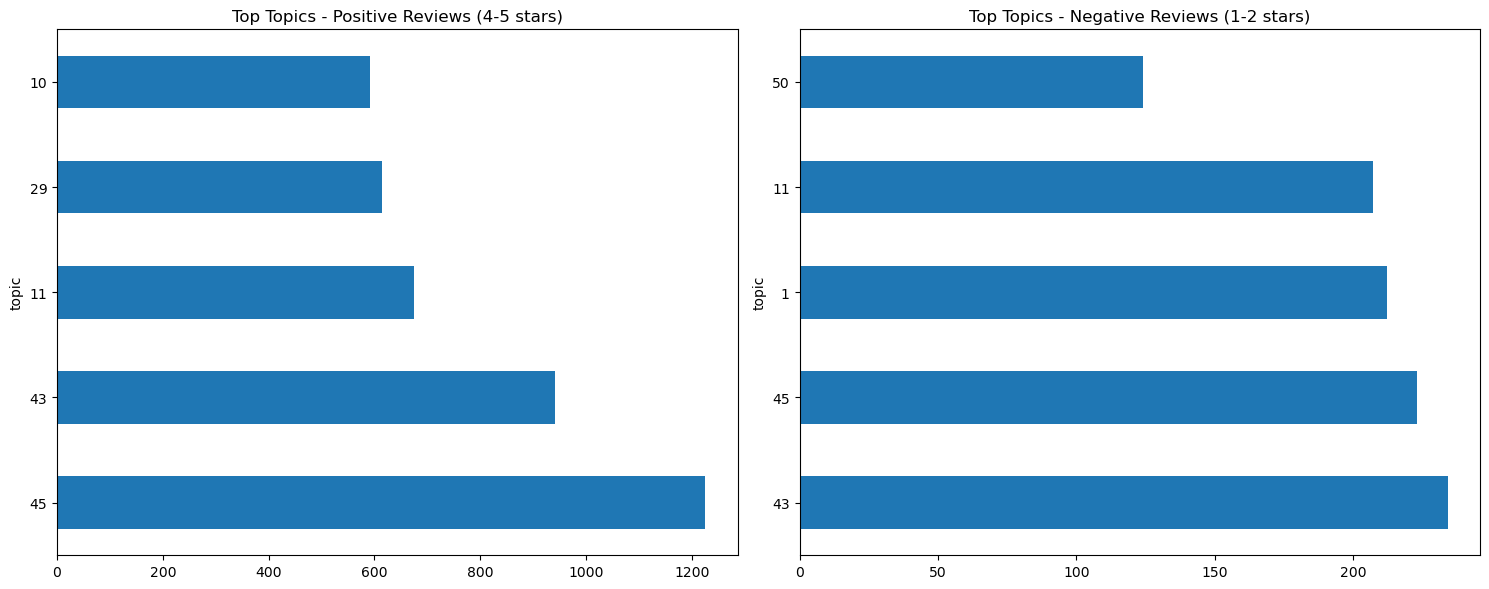

In [90]:
# ==========================
# ADVANCED ANALYSIS IDEAS
# ==========================

# 1. SEGMENTATION BY STAR RATINGS (Easy)
# =====================================
print("1. Analysis by Star Ratings")
print("="*40)

# Separate positive vs negative reviews
positive_reviews = reviews_df[reviews_df['overall'] >= 4]
negative_reviews = reviews_df[reviews_df['overall'] <= 2]
neutral_reviews = reviews_df[reviews_df['overall'] == 3]

# Compare topic distributions
positive_topics = positive_reviews['topic'].value_counts().head(5)
negative_topics = negative_reviews['topic'].value_counts().head(5)

print("Top topics in positive reviews:")
print(positive_topics)
print("\nTop topics in negative reviews:")  
print(negative_topics)

# Visualize the comparison
import matplotlib.pyplot as plt
import seaborn as sns

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
positive_topics.plot(kind='barh', ax=ax1, title='Top Topics - Positive Reviews (4-5 stars)')
negative_topics.plot(kind='barh', ax=ax2, title='Top Topics - Negative Reviews (1-2 stars)')
plt.tight_layout()
plt.show()


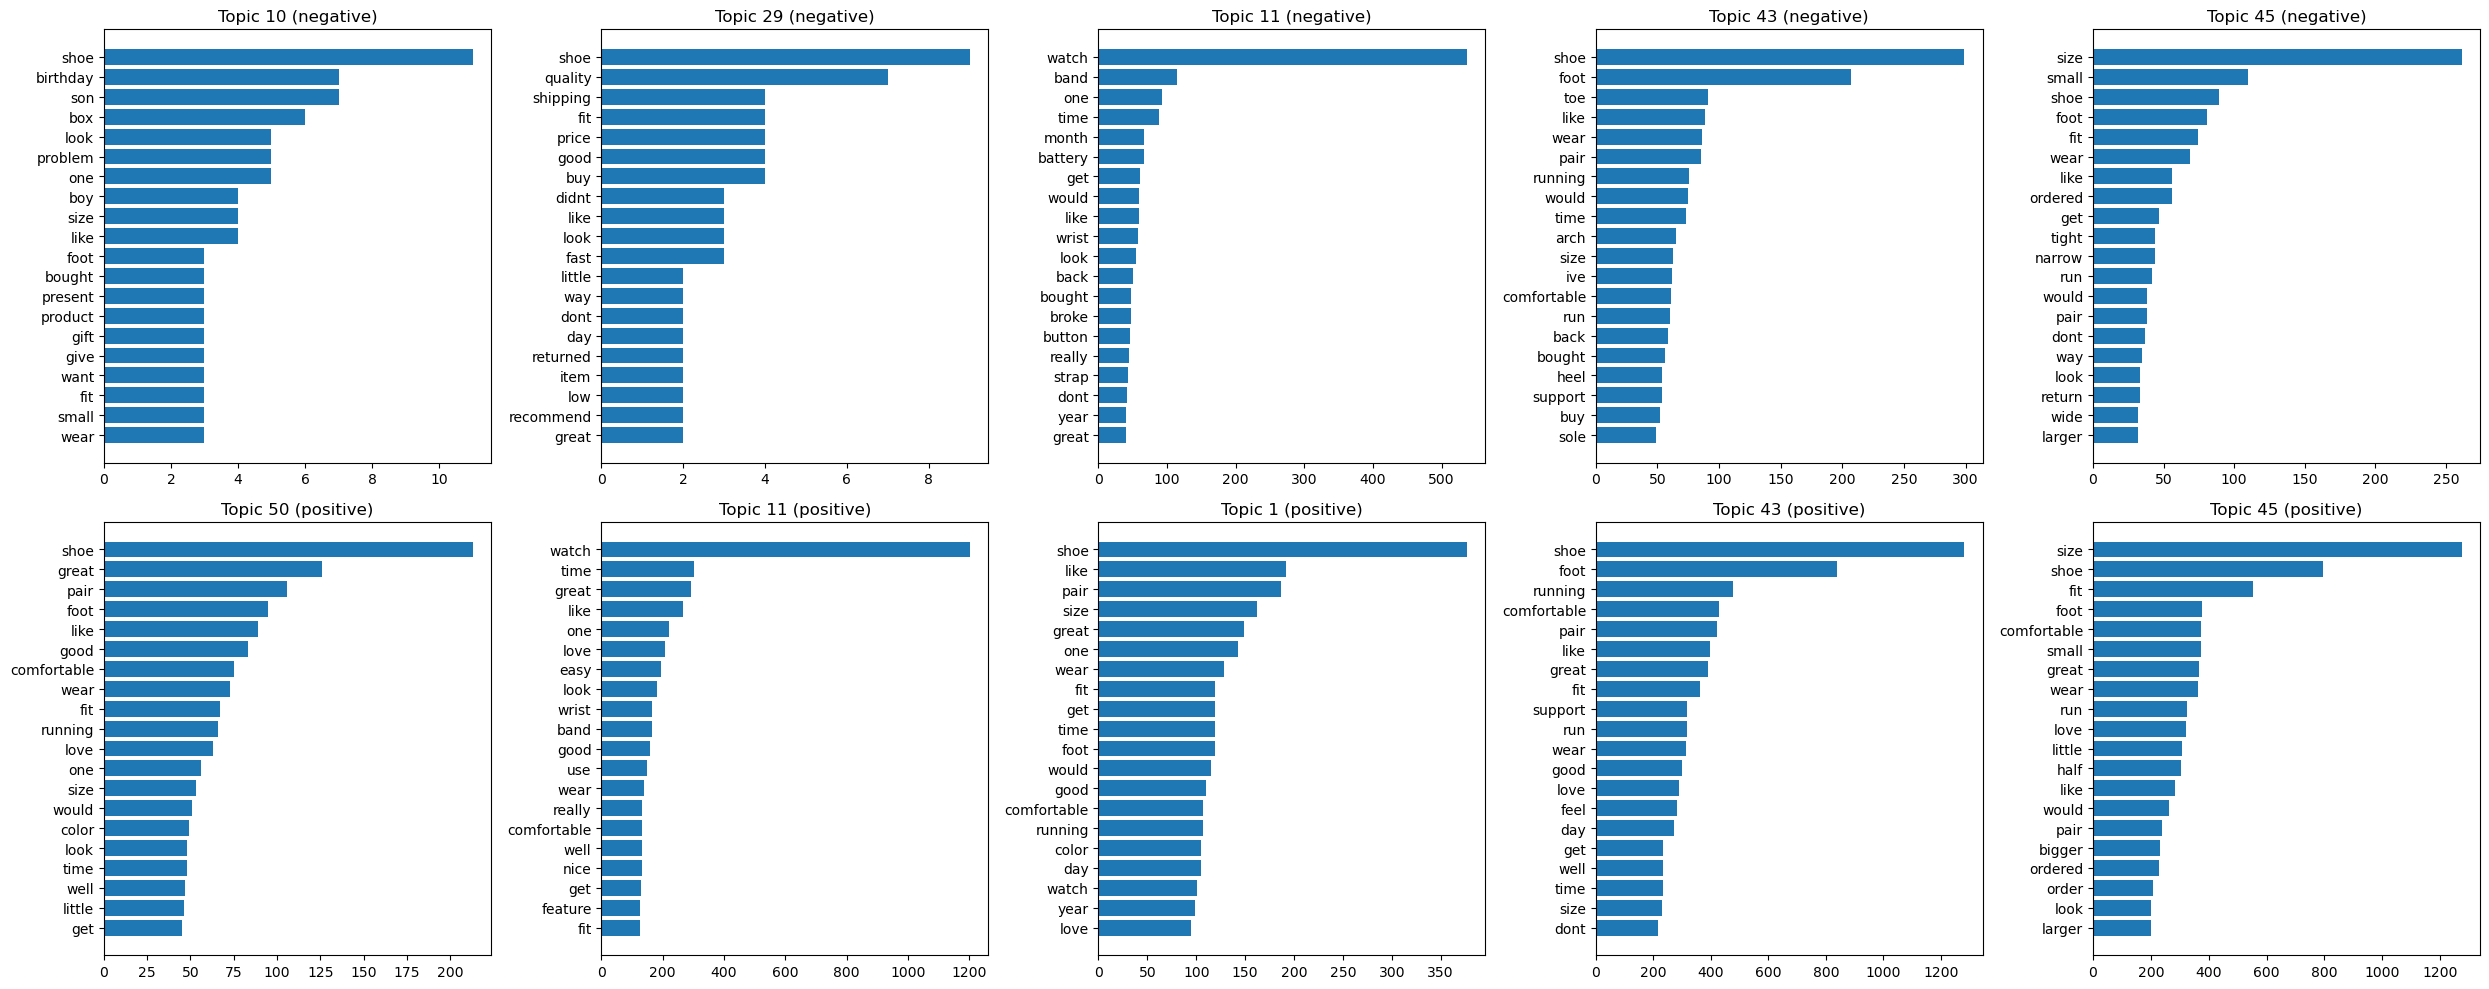

In [144]:
# ==========================================
# WORD FREQUENCIES PER TOPIC (POS vs NEG)
# ==========================================

from collections import Counter
import matplotlib.pyplot as plt

def get_top_words(df, topic_id, sentiment_label, n=20):
    """
    df: reviews dataframe
    topic_id: int, topic number
    sentiment_label: 'positive' or 'negative'
    n: top N words
    """
    if sentiment_label == "negative":
        subset = df[(df['topic'] == topic_id) & (df['overall'] <= 2)]
    elif sentiment_label == "positive":
        subset = df[(df['topic'] == topic_id) & (df['overall'] >= 4)]
    else:
        raise ValueError("sentiment_label must be 'positive' or 'negative'")
    
    # Flatten all tokens from 'cleaned' (assumes it's tokenized list or space-separated string)
    words = []
    for text in subset['cleaned']:
        if isinstance(text, str):
            words.extend(text.split())
        elif isinstance(text, list):
            words.extend(text)
    
    return Counter(words).most_common(n)


# Define target topics
negative_topics_list = [10, 29, 11, 43, 45]
positive_topics_list = [50, 11, 1, 43, 45]

# Collect results
topic_word_stats = {}

for t in negative_topics_list:
    topic_word_stats[(t, 'negative')] = get_top_words(reviews_df, t, 'negative', n=20)

for t in positive_topics_list:
    topic_word_stats[(t, 'positive')] = get_top_words(reviews_df, t, 'positive', n=20)


# ========== DISPLAY RESULTS (commented out the print) ==========
#for (topic_id, sentiment), words in topic_word_stats.items():
#    print(f"\nTop words for topic {topic_id} ({sentiment} reviews):")
#    for word, count in words:
#        print(f"{word}: {count}")

fig, axes = plt.subplots(2, 5, figsize=(25, 10))
axes = axes.flatten()

for idx, ((topic_id, sentiment), words) in enumerate(topic_word_stats.items()):
    labels, values = zip(*words) if words else ([], [])
    axes[idx].barh(labels, values)
    axes[idx].set_title(f"Topic {topic_id} ({sentiment})")
    axes[idx].invert_yaxis()

plt.tight_layout()
plt.show()


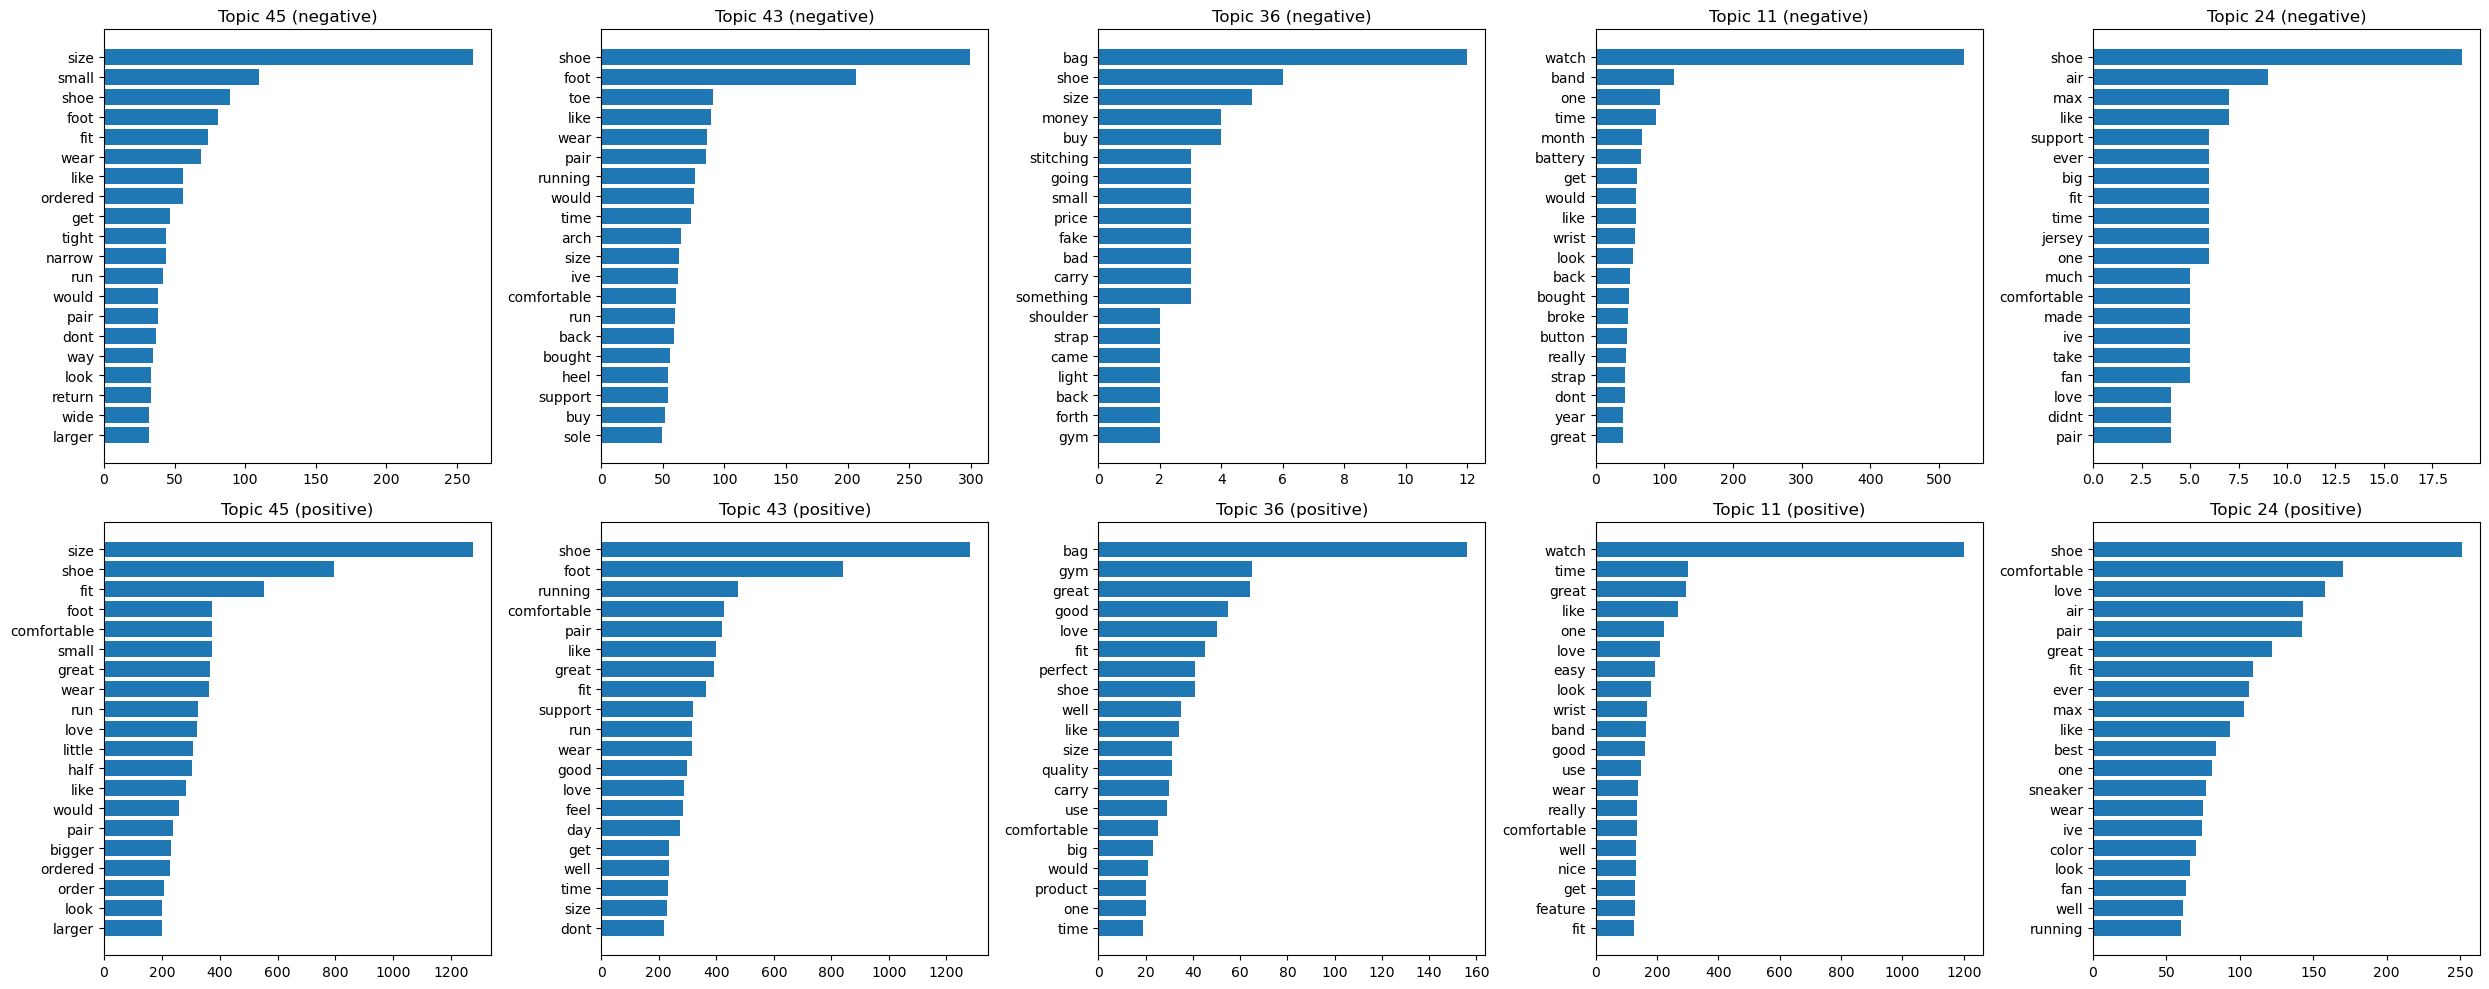

In [161]:
# Define target topics
negative_topics_list = [45, 43, 36, 11, 24]
positive_topics_list = [45, 43, 36, 11, 24]

# Collect results
topic_word_stats = {}

for t in negative_topics_list:
    topic_word_stats[(t, 'negative')] = get_top_words(reviews_df, t, 'negative', n=20)

for t in positive_topics_list:
    topic_word_stats[(t, 'positive')] = get_top_words(reviews_df, t, 'positive', n=20)


# ========== DISPLAY RESULTS (commented out the print) ==========
#for (topic_id, sentiment), words in topic_word_stats.items():
#    print(f"\nTop words for topic {topic_id} ({sentiment} reviews):")
#    for word, count in words:
#        print(f"{word}: {count}")

fig, axes = plt.subplots(2, 5, figsize=(25, 10))
axes = axes.flatten()

for idx, ((topic_id, sentiment), words) in enumerate(topic_word_stats.items()):
    labels, values = zip(*words) if words else ([], [])
    axes[idx].barh(labels, values)
    axes[idx].set_title(f"Topic {topic_id} ({sentiment})")
    axes[idx].invert_yaxis()

plt.tight_layout()
plt.show()


In [148]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# topic_word_stats: dict keyed by (topic_id, sentiment) -> [(word, count), ...]
pairs = list(topic_word_stats.items())  # preserves ordering
rows, cols = 5, 2                       # 5 rows x 2 cols = 10 slots

# Titles for each subplot
titles = [f"Topic {tid} ({sent})" for (tid, sent), _ in pairs]

fig = make_subplots(
    rows=rows, cols=cols,
    subplot_titles=titles,
    horizontal_spacing=0.15,
    vertical_spacing=0.1
)

# Add the 10 plots into the grid (row-major order)
for idx, ((topic_id, sentiment), words) in enumerate(pairs):
    row = idx // cols + 1
    col = idx % cols + 1

    if words:
        labels, values = zip(*words)
        labels, values = list(labels), list(values)
    else:
        labels, values = [], []

    fig.add_trace(
        go.Bar(
            x=values,
            y=labels,
            orientation='h',
            hovertemplate="Word: %{y}<br>Count: %{x}<extra></extra>"
        ),
        row=row, col=col
    )

    # Invert y-axis (like matplotlib barh)
    fig.update_yaxes(
        autorange="reversed",
        automargin=True,
        tickfont=dict(size=10),
        row=row, col=col
    )
    fig.update_xaxes(automargin=True, row=row, col=col)

# Layout tweaks
fig.update_layout(
    height=1500,
    width=1000,
    title_text="Top Words by Topic (Positive vs Negative) — 2 cols × 5 rows",
    showlegend=False,
    margin=dict(l=100, r=60, t=100, b=60)
)

fig.show()


In [156]:
import random
import plotly.graph_objects as go
from plotly.subplots import make_subplots

print("positive is 4+ stars, negative is 2- stars.")

# -------------------------------
# Define topic groups
# -------------------------------
topic_ids = [45, 43, 36, 11, 24]

# -------------------------------
# Function to get top ASINs and sample reviews
# -------------------------------
def get_top_asins_with_reviews(subset, n_asins=5, n_reviews=3, max_len=150):
    top_asins = subset['asin'].value_counts().head(n_asins)
    hover_texts = []

    for asin in top_asins.index:
        reviews = subset[subset['asin'] == asin]['reviewText'].dropna().tolist()
        if not reviews:
            hover_texts.append("No reviews available")
            continue
        sample_reviews = random.sample(reviews, min(len(reviews), n_reviews))

        truncated_reviews = []
        for review in sample_reviews:
            review_str = str(review)
            if len(review_str) > max_len:
                truncated_reviews.append(review_str[:max_len] + "...")
            else:
                truncated_reviews.append(review_str)

        hover_text = "<br>".join(truncated_reviews)
        hover_texts.append(hover_text)

    return top_asins, hover_texts

# -------------------------------
# Collect data for each topic/sentiment
# -------------------------------
all_topic_asins = {}

for t in topic_ids:
    # Negative reviews
    subset_neg = reviews_df[(reviews_df['topic'] == t) & (reviews_df['overall'] <= 2)]
    top_asins_neg, hover_neg = get_top_asins_with_reviews(subset_neg)
    all_topic_asins[(t, 'Negative')] = (top_asins_neg, hover_neg)

    # Positive reviews
    subset_pos = reviews_df[(reviews_df['topic'] == t) & (reviews_df['overall'] >= 4)]
    top_asins_pos, hover_pos = get_top_asins_with_reviews(subset_pos)
    all_topic_asins[(t, 'Positive')] = (top_asins_pos, hover_pos)

# -------------------------------
# Prepare subplot layout
# -------------------------------
rows = len(topic_ids)
cols = 2  # Negative | Positive
titles = []
for t in topic_ids:
    titles.extend([f"Topic {t} (Negative)", f"Topic {t} (Positive)"])

fig = make_subplots(
    rows=rows, cols=cols,
    subplot_titles=titles,
    horizontal_spacing=0.15,
    vertical_spacing=0.15
)

# -------------------------------
# Add ASIN bar charts
# -------------------------------
for row_idx, t in enumerate(topic_ids, start=1):
    for col_idx, sentiment in enumerate(['Negative', 'Positive'], start=1):
        asin_counts, hover_texts = all_topic_asins[(t, sentiment)]
        labels = asin_counts.index.tolist()
        values = asin_counts.values.tolist()

        fig.add_trace(
            go.Bar(
                x=values,
                y=labels,
                orientation='h',
                hovertemplate=[
                    f"ASIN: {asin}<br>Count: {count}<br><br>Sample Reviews:<br>{hover}"
                    for asin, count, hover in zip(labels, values, hover_texts)
                ]
            ),
            row=row_idx, col=col_idx
        )

        fig.update_yaxes(autorange="reversed", automargin=True, tickfont=dict(size=10), row=row_idx, col=col_idx)
        fig.update_xaxes(automargin=True, row=row_idx, col=col_idx)

# -------------------------------
# Layout tweaks
# -------------------------------
fig.update_layout(
    height=1500,
    width=1000,
    title_text="Top 5 ASINs per Topic (Negative vs Positive) with Sample Reviews",
    showlegend=False,
    margin=dict(l=100, r=60, t=100, b=60)
)

fig.show()


positive is 4+ stars, negative is 2- stars.


In [99]:
# 3. TEMPORAL ANALYSIS 
# ==================================
print("\n3. Temporal Analysis")
print("="*40)

# Convert reviewTime to datetime if not already
reviews_df['reviewTime'] = pd.to_datetime(reviews_df['reviewTime'])
reviews_df['year'] = reviews_df['reviewTime'].dt.year
reviews_df['month'] = reviews_df['reviewTime'].dt.month

# Seasonal analysis
seasonal_topics = reviews_df.groupby(['month', 'topic']).size().unstack(fill_value=0)
print("\nTopic trends by month (seasonality):")
print(seasonal_topics.head(12))



3. Temporal Analysis

Topic trends by month (seasonality):
topic  0   1   2   3   4   5   6   7   8   9   10   11  12  13  14  15  16  \
month                                                                        
1      12  72  33   6   6  10  10  29  25   8  64  122   8  13   9  22   8   
2       8  60  28   8   9   4   4  20  27  10  60   90  10  13   7  22  12   
3      19  65  41   6   7  11   9  33  34  12  60   85  16  21  14  29  20   
4       9  99  37  11  16  22  15  28  45  11  65   85  16  29  20  38  12   
5       6  68  40  11   5   9   8  27  31  14  84   84  17  20  11  27  10   
6       7  58  47  10   4   9   4  36  35  13  52   76  16  16  13  35  12   
7      32  70  25  14  12  13   7  30  27  10  52   71  15  12   8  29  26   
8       4  37  22   5   7   6   7  16  19   5  31   73   9   9   5   9   6   
9       7  33  33   4   3   5   2  19  19   7  27   80   8  13   6  12   7   
10      3  49  15   3   4   5   5  15  15   3  30   75   6   8  10  11   9   
11  

In [100]:
import numpy as np
import pandas as pd

# Ensure reviewTime is datetime
reviews_df['reviewTime'] = pd.to_datetime(reviews_df['reviewTime'])
reviews_df['month'] = reviews_df['reviewTime'].dt.month

# Count reviews per month per topic
seasonal_topics = reviews_df.groupby(['month', 'topic']).size().unstack(fill_value=0)

# Log-transform counts (add 1 to avoid log(0))
log_counts = np.log1p(seasonal_topics)

# Mean across topics for each month
month_popularity = log_counts.sum(axis=1)

# Display
print("Log-transformed summed review counts per month:")
print(month_popularity)


Log-transformed summed review counts per month:
month
1     226.242530
2     218.850981
3     239.386357
4     238.838539
5     230.394197
6     233.978246
7     236.247754
8     184.782989
9     184.760086
10    183.625588
11    185.677056
12    221.749488
dtype: float64


In [101]:
import plotly.graph_objs as go

# month_popularity from last snippet (total reviews per month)
fig = go.Figure(
    data=go.Bar(
        x=month_popularity.index, 
        y=month_popularity.values,
        text=month_popularity.values,  # show raw counts on hover
        textposition='auto',
        marker_color='teal',
        hovertemplate="Month: %{x}<br>Total Reviews: %{y}<extra></extra>"
    )
)

fig.update_layout(
    title="Total Reviews per Month Across All Topics (log transformed)",
    xaxis_title="Month",
    yaxis_title="Total Reviews",
    xaxis=dict(tickmode='linear'),
    yaxis=dict(range=[150, 250]),  # zoomed range
    template='plotly_white',
    height=500
)

fig.show()


In [102]:

# 4. SENTIMENT ANALYSIS ENHANCEMENT 
# ===============================================
print("\n4. Enhanced Sentiment Analysis")
print("="*40)

from textblob import TextBlob

# Add sentiment scores
def get_sentiment(text):
    return TextBlob(str(text)).sentiment.polarity

reviews_df['sentiment_score'] = reviews_df['reviewText'].apply(get_sentiment)
reviews_df['sentiment_category'] = pd.cut(
    reviews_df['sentiment_score'], 
    bins=[-1, -0.1, 0.1, 1], 
    labels=['Negative', 'Neutral', 'Positive']
)

# Analyze topics by sentiment
sentiment_topics = reviews_df.groupby(['sentiment_category', 'topic']).size().unstack(fill_value=0)
print("Topics by sentiment category:")
print(sentiment_topics)



4. Enhanced Sentiment Analysis
Topics by sentiment category:
topic               0    1    2   3   4   5   6    7    8   9    10   11   12  \
sentiment_category                                                              
Negative             2   66    5  13   7  13   5   13    6   3   12   56    5   
Neutral             37  214   35  18  11  33  12   47   46  11   42  223   18   
Positive            78  418  334  56  65  63  60  248  272  88  562  735  113   

topic                13  14   15   16  17   18   19   20   21   22   23   24  \
sentiment_category                                                             
Negative              8   6   12    6  18    6   15   16   11    1    3   14   
Neutral              26  18   39    9  23   27   48   83   52   21  184   42   
Positive            144  94  218  121  53  202  200  320  454  152   30  431   

topic               25   26  27   28   29   30   31   32   33  34   35   36  \
sentiment_category                                  

In [103]:
# 4b. TOP NEGATIVELY PERCEIVED TOPICS BY NEG/POS RATIO
# =====================================================
print("\nTop Negatively Perceived Topics (by Negative/Positive Ratio)")
print("="*60)

# Aggregate counts of each sentiment per topic (if not already)
sentiment_topics = reviews_df.groupby(['topic', 'sentiment_category']).size().unstack(fill_value=0)

# Compute Negative/Positive ratio
sentiment_topics['neg_pos_ratio'] = sentiment_topics.apply(
    lambda row: row['Negative'] / row['Positive'] if row['Positive'] > 0 else float('inf'),
    axis=1
)

# Sort topics by negative-to-positive ratio
top_negative_topics = sentiment_topics.sort_values('neg_pos_ratio', ascending=False)

# Display top 10 most negatively perceived topics
print(top_negative_topics[['Negative', 'Positive', 'Neutral', 'neg_pos_ratio']].head(10))




Top Negatively Perceived Topics (by Negative/Positive Ratio)
sentiment_category  Negative  Positive  Neutral  neg_pos_ratio
topic                                                         
17                        18        53       23       0.339623
57                        45       133       83       0.338346
3                         13        56       18       0.232143
5                         13        63       33       0.206349
37                         9        46       26       0.195652
50                        54       297      133       0.181818
48                        18       108       31       0.166667
1                         66       418      214       0.157895
46                        19       141       44       0.134752
70                        10        80       29       0.125000


In [104]:

# 5. PRICE SENSITIVITY ANALYSIS (Intermediate)
# ============================================
print("\n5. Price Sensitivity Analysis")
print("="*40)

# Look for price-related keywords in reviews
price_keywords = ['price', 'expensive', 'cheap', 'value', 'worth', 'cost', 'deal', 'money']
price_mentions = reviews_df[reviews_df['reviewText'].str.contains('|'.join(price_keywords), case=False, na=False)]

print(f"Reviews mentioning price: {len(price_mentions)} out of {len(reviews_df)} ({len(price_mentions)/len(reviews_df)*100:.1f}%)")

# Analyze topics in price-sensitive reviews
price_topics = price_mentions['topic'].value_counts().head(10)
print("\nTop topics in price-sensitive reviews:")
print(price_topics)



5. Price Sensitivity Analysis
Reviews mentioning price: 3662 out of 21570 (17.0%)

Top topics in price-sensitive reviews:
topic
43    248
1     237
11    205
71    173
45    169
29    158
50    108
49     99
10     96
53     86
Name: count, dtype: int64


In [105]:

# 6. PRODUCT LIFECYCLE ANALYSIS (Advanced)
# ========================================
print("\n6. Product Lifecycle Analysis")
print("="*40)

# Analyze how topics change for products over time since launch
product_lifecycle = reviews_df.groupby(['asin', 'year', 'topic']).size().reset_index(name='count')

# Find products with long review histories
products_with_history = reviews_df.groupby('asin')['year'].nunique()
long_history_products = products_with_history[products_with_history >= 3]

print(f"Products with 3+ years of reviews: {len(long_history_products)}")

print(long_history_products.sort_values(ascending=False).head(10))


6. Product Lifecycle Analysis
Products with 3+ years of reviews: 365
asin
B000E8J5PY    7
B000A8BUEC    6
B000NOCJJS    6
B001V6PNRW    6
B000A8BU0Q    6
B0030NKIH4    5
B000E8F2TM    5
B000E8H01K    5
B000E8H0LA    5
B003QL2SQO    5
Name: year, dtype: int64


In [106]:

# 8. REVIEW DEPTH ANALYSIS (Intermediate)
# =======================================
print("\n8. Review Depth Analysis")
print("="*40)

# Analyze review length and its relationship to topics
reviews_df['review_length'] = reviews_df['reviewText'].str.len()
reviews_df['review_depth'] = pd.cut(
    reviews_df['review_length'], 
    bins=[0, 100, 500, float('inf')], 
    labels=['Short', 'Medium', 'Long']
)

depth_topics = reviews_df.groupby(['review_depth', 'topic']).size().unstack(fill_value=0)
print("Topics by review depth:")
print(depth_topics.head())



8. Review Depth Analysis
Topics by review depth:
topic         0    1    2   3   4   5   6    7    8   9    10   11   12   13  \
review_depth                                                                   
Short         36   15   23  15  15   9   6   22   17   7   49   41   11    7   
Medium        80  448  340  68  68  96  71  283  294  94  556  714  123  163   
Long           1  235   11   4   0   4   0    3   13   1   11  259    2    8   

topic          14   15   16  17   18   19   20   21   22   23   24  25   26  \
review_depth                                                                  
Short           9   24   33  12   15   22   21   55    6   20   34   7   30   
Medium        108  234  103  80  213  237  346  455  167  193  436  50  211   
Long            1   11    0   2    7    4   52    7    1    4   17   0    4   

topic         27   28   29   30   31   32   33  34   35   36  37  38   39  \
review_depth                                                                

In [107]:

# 9. FEATURE IMPORTANCE ANALYSIS (Advanced)
# =========================================
print("\n9. Feature Importance Analysis")
print("="*40)

# Extract specific product features mentioned
feature_keywords = {
    'comfort': ['comfort', 'comfortable', 'cozy'],
    'durability': ['durable', 'lasting', 'sturdy', 'quality'],
    'design': ['design', 'style', 'look', 'appearance'],
    'fit': ['fit', 'size', 'sizing', 'tight', 'loose'],
    'performance': ['performance', 'speed', 'grip', 'traction']
}

for feature, keywords in feature_keywords.items():
    feature_reviews = reviews_df[reviews_df['reviewText'].str.contains('|'.join(keywords), case=False, na=False)]
    feature_topics = feature_reviews['topic'].value_counts().head(5)
    print(f"\nTop topics mentioning {feature}:")
    print(feature_topics)



9. Feature Importance Analysis

Top topics mentioning comfort:
topic
43    552
45    447
72    224
24    201
29    183
Name: count, dtype: int64

Top topics mentioning durability:
topic
29    154
45    134
43    117
11    104
20     82
Name: count, dtype: int64

Top topics mentioning design:
topic
45    441
43    393
11    392
1     217
10    165
Name: count, dtype: int64

Top topics mentioning fit:
topic
45    1380
43     598
1      292
71     254
11     248
Name: count, dtype: int64

Top topics mentioning performance:
topic
43    74
69    43
72    35
11    25
45    21
Name: count, dtype: int64


In [108]:
# 10. ACTIONABLE INSIGHTS GENERATOR 
# ============================================
print("\n10. Actionable Insights Generator")
print("="*40)

from collections import Counter
import re

def get_top_words(text_series, n_words=10):
    """Extract top words from a series of text"""
    # Combine all text and clean it
    all_text = ' '.join(text_series.astype(str))
    # Remove punctuation and convert to lowercase
    words = re.findall(r'\b[a-zA-Z]{3,}\b', all_text.lower())
    # Remove common stopwords
    stopwords = {'the', 'and', 'for', 'are', 'but', 'not', 'you', 'all', 'can', 'had', 'her', 'was', 'one', 'our', 'out', 'day', 'get', 'has', 'him', 'his', 'how', 'man', 'new', 'now', 'old', 'see', 'two', 'way', 'who', 'boy', 'did', 'its', 'let', 'put', 'say', 'she', 'too', 'use', 'this', 'that', 'with', 'have', 'from', 'they', 'know', 'want', 'been', 'good', 'much', 'some', 'time', 'very', 'when', 'come', 'here', 'just', 'like', 'long', 'make', 'many', 'over', 'such', 'take', 'than', 'them', 'well', 'were', 'will'}
    filtered_words = [word for word in words if word not in stopwords and len(word) > 3]
    return Counter(filtered_words).most_common(n_words)

def generate_insights(topic_id):
    """Generate specific insights for a topic"""
    topic_reviews = reviews_df[reviews_df['topic'] == topic_id]
    
    insights = {
        'topic_id': topic_id,
        'total_reviews': len(topic_reviews),
        'avg_rating': topic_reviews['overall'].mean(),
        'sentiment_distribution': topic_reviews['sentiment_category'].value_counts() if 'sentiment_category' in reviews_df.columns else 'N/A',
        'top_products': topic_reviews['asin'].value_counts().head(3),
        'seasonal_pattern': topic_reviews['month'].value_counts().head(3) if 'month' in reviews_df.columns else 'N/A',
        'top_words': get_top_words(topic_reviews['reviewText'], 15),
        'sample_reviews': topic_reviews['reviewText'].head(3).tolist()
    }
    
    return insights

# Example: Generate insights for topics
top_topics = reviews_df['topic'].value_counts().head(30).index
for topic in top_topics:
    insights = generate_insights(topic)
    print(f"\nInsights for Topic {topic}:")
    print(f"- Reviews: {insights['total_reviews']}")
    print(f"- Avg Rating: {insights['avg_rating']:.2f}")
    print(f"- Top Product: {insights['top_products'].index[0]} ({insights['top_products'].iloc[0]} reviews)")
    print(f"- Top Words: {', '.join([f'{word}({count})' for word, count in insights['top_words'][:10]])}")
    print(f"- Product Clues: {', '.join([word for word, count in insights['top_words'][:15] if any(keyword in word.lower() for keyword in ['shoe', 'boot', 'sneaker', 'shirt', 'jacket', 'watch', 'phone', 'case', 'bag', 'nike', 'adidas', 'apple', 'samsung'])])}")



10. Actionable Insights Generator

Insights for Topic 45:
- Reviews: 1702
- Avg Rating: 3.98
- Top Product: B000V4YZ1K (62 reviews)
- Top Words: size(1750), shoes(1018), these(1007), shoe(690), small(607), wear(457), nike(454), comfortable(434), great(431), half(382)
- Product Clues: shoes, shoe, nike

Insights for Topic 43:
- Reviews: 1319
- Avg Rating: 3.95
- Top Product: B004IM1GHW (26 reviews)
- Top Words: shoes(1784), these(1621), shoe(1209), nike(725), feet(722), running(625), comfortable(548), pair(508), foot(481), great(460)
- Product Clues: shoes, shoe, nike

Insights for Topic 11:
- Reviews: 1014
- Avg Rating: 3.77
- Top Product: B000E8H01K (18 reviews)
- Top Words: watch(1857), nike(403), great(373), band(317), wrist(248), only(241), easy(229), really(216), would(212), these(207)
- Product Clues: watch, nike, watches

Insights for Topic 1:
- Reviews: 698
- Avg Rating: 3.49
- Top Product: B007FXKMLW (40 reviews)
- Top Words: shoes(648), these(569), shoe(438), nike(414), size

Number of unique reviewers: 20423
Top Reviewers:
reviewerID
A32D0TORRTI9E5    11
ARE2MDLUM3APW      7
A265PCQZA1Y1WF     7
A237P6ACWJR9LM     7
A1PR0WW5UQHL7X     6
A2OAWB0RRB6QNQ     5
A2J3QP96I96P4B     5
AC441KJETNFXS      5
A3FP6ZIBTMCPCF     5
A3HJOKYEV152QJ     5
Name: count, dtype: int64


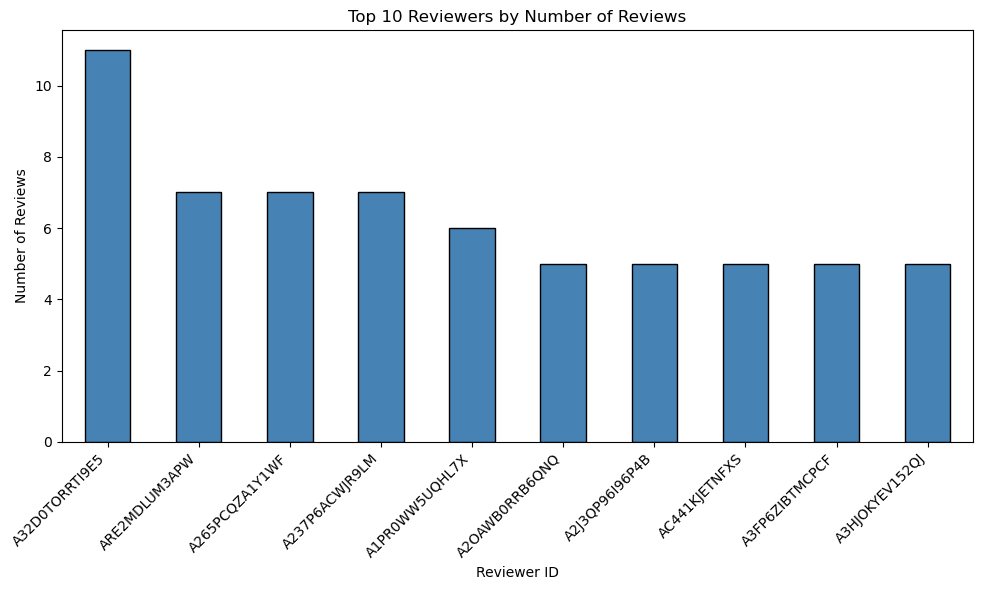

In [109]:
import pandas as pd
import matplotlib.pyplot as plt

uniquereviewers = reviews_df['reviewerID'].nunique()
print(f'Number of unique reviewers: {uniquereviewers}')  # Total unique reviewers in the dataset

# --- Top Reviewers Script ---
def plot_top_reviewers(df, n=10):
    """
    Show top reviewers by number of reviews.
    Args:
        df: DataFrame with 'reviewerID' column
        n: number of top reviewers to display
    """
    # Count reviews per reviewer
    top_reviewers = df['reviewerID'].value_counts().head(n)

    # Print table for reference

    print("Top Reviewers:")
    print(top_reviewers)
    
    
    # Plot
    plt.figure(figsize=(10, 6))
    top_reviewers.plot(kind='bar', color='steelblue', edgecolor='black')
    plt.title(f"Top {n} Reviewers by Number of Reviews")
    plt.xlabel("Reviewer ID")
    plt.ylabel("Number of Reviews")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# --- Example usage ---
plot_top_reviewers(reviews_df, n=10)



In [110]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_top_reviewer_topics(df, n=10):
    """
    Show distribution of topics reviewed by top reviewers.
    Args:
        df: DataFrame with 'reviewerID' and 'topic' columns
        n: number of top reviewers to display
    """
    # Get top reviewers
    top_reviewers = df['reviewerID'].value_counts().head(n).index

    # Filter down to their reviews
    subset = df[df['reviewerID'].isin(top_reviewers)]

    # Build pivot table: reviewers (rows) x topics (columns)
    reviewer_topics = pd.crosstab(subset['reviewerID'], subset['topic'])

    # Print table for reference
    print("Top Reviewer → Topic counts:")
    print(reviewer_topics)

# --- Example usage ---
plot_top_reviewer_topics(reviews_df, n=10)


Top Reviewer → Topic counts:
topic           0   8   10  11  12  14  15  16  18  23  24  25  29  30  32  \
reviewerID                                                                   
A1PR0WW5UQHL7X   0   0   1   0   0   0   0   1   0   0   0   0   0   0   0   
A237P6ACWJR9LM   0   1   0   0   1   0   0   0   0   0   0   0   0   0   1   
A265PCQZA1Y1WF   0   0   0   0   0   0   0   0   0   0   1   0   0   0   0   
A2J3QP96I96P4B   0   0   1   0   0   0   0   0   0   0   0   0   1   1   0   
A2OAWB0RRB6QNQ   0   0   0   0   0   0   0   0   0   1   0   4   0   0   0   
A32D0TORRTI9E5   0   2   0   1   0   1   0   0   1   0   0   1   0   0   1   
A3FP6ZIBTMCPCF   1   0   0   2   0   0   0   0   0   0   0   0   0   0   0   
A3HJOKYEV152QJ   0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   
AC441KJETNFXS    0   0   0   0   0   0   0   0   0   0   0   0   1   0   0   
ARE2MDLUM3APW    0   0   0   0   0   0   0   1   0   0   2   0   1   0   0   

topic           36  39  40  43  45

In [164]:
import plotly.io as pio

# Use the notebook renderer
pio.renderers.default = "notebook_connected"


### CMD Prompt in Project Directory (cd projectdirectory)

jupyter nbconvert --to html --execute --output exported_notebook.html UnsupervisedTextModeling.ipynb